# <b>MODIS Water Validation Notebook</b>

Purpose: Used to perform validation of C61 V4 MOD44W products. Compares those products to the previous version, C6 MOD44W.

*Note: We are following an incremental development lifecycle. This notebook is the first rendition which fit most of the requirements. Expect incremental releases which continue towards the goal of fully meeting requirements and increasing capabilities of the user.*

Installation requirements:

```bash
pip install localtileserver
```

TODO:
- ipysheet for user to input comments
- load layers from toolbar
- move everything inside a class to avoid user input

Some references:

- https://towardsdatascience.com/bring-your-jupyter-notebook-to-life-with-interactive-widgets-bc12e03f0916
- https://github.com/giswqs/geodemo/blob/master/geodemo/common.py

Version: 4.0.0
Date: 10/05/2022

*For DSG internal use*

### <b> WARNING </b>

Do not run all cells at once, doing so will shut down the local tile servers before you, the user, can interact.

Uncomment if localtileserver is not installed

In [2]:
# !pip install localtileserver

In [3]:
import os
import re
import json
import joblib
import tempfile
import ipysheet
import numpy as np
import pandas as pd
import rasterio as rio
import rioxarray as rxr
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import ipywidgets as widgets
import warnings
import tempfile

from osgeo import gdal
from pprint import pprint

from glob import glob

## Tile and year selection

Choose which tile (see MODIS grid) and which year. Reference the grid image. 

The `h` followed by two numerical digits represent the <b>horizontal</b> tile ID. Use the column space to determine this ID. 

The `v` followed by two numerical digits represent the <b>vertical</b> tile ID. Use the row space to determine this ID. 

For example, the tile that is 9 columns to the right and 5 rows down is `h09v05`.

Example:
```python
TILE = 'h09v05'
```

![MODIS Grid Overlay](../imgs/modis_overlay.png)

In [29]:
# TILE = 'h32v12'
# TILE = 'h11v02'
# TILE = 'h05v13'
TILE = 'h22v01'

## NOTICE

Only 2019 is available :D 

In [30]:
YEAR = 2019

Shouldn't need to change anything under this 

In [31]:
MOD44W_C6_BASEPATH = '/explore/nobackup/people/mcarrol2/MODIS_water/v5_outputs/'
MOD44W_V3_C61_BASEPATH = '/explore/nobackup/projects/ilab/data/MODIS/PRODUCTION/MODAPS_test3_07202023/MOD44W-LandWaterMask/'
MOD44W_V4_C61_BASEPATH = '/explore/nobackup/projects/ilab/data/MODIS/PRODUCTION/MODAPS_test4_09272023/MOD44W-LandWaterMask'
MOD44W_C61_VERSION = '001'
C6_FILE_TYPE = '.tif'
C61_FILE_TYPE = '.hdf'

TMP_FILE_TYPE = '.tif'

HDF_PRESTR = 'HDF4_EOS:EOS_GRID'
HDF_POSSTR = 'MOD44W_250m_GRID'

SEVEN_CLASS = 'seven_class'
WATER_MASK = 'water_mask'
WATER_MASK_QA = 'water_mask_QA'

if YEAR > 2019:
    warnings.warn('Using 2019 C6 MOD44W')
    MOD44_C6_YEAR = 2019
else:
    MOD44_C6_YEAR = YEAR

tiles_basemap: str = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}'
water_c6_cmap: list = ['#E3B878', '#2d7d86']
water_v4_c61_cmap: list = ['#194d33', '#8ed1fc']
water_v3_c61_cmap: list = ['#194d33', '#8a94fc']
seven_class_cmap: list = ['#0057d7', '#e6c9a8', '#d700d5', '#00d7d0', '#d70000', '#9f00c7', '#000AD0', '#000564']
# water_qa_cmap: list = ['#FF6900', '#FCB900', '#7BDCB5', '#dd00ff', '#0693E3', '#ff6900', '#EB144C', '#F78DA7', '#9900EF']
water_qa_cmap: list = ['#79d2a6', '#ff6900', '#e4efe9']
difference_cmap: list = ['#b8174e', '#00e202']
water_qa_cmap_dict: dict = {
    1: ('High Confidence Observation', '#7BDCB5'),# '#7BDCB5'
    2: ('Low Confidence Water', '#ee82ee'),
    3: ('Low Confidence Land', '#F78DA7'),
    4: ('Ocean Mask', '#FCB900'),
    5: ('Ocean Mask but no water detected', '#0693E3'),
    6: ('Burn Scar (from MCD64A1)', '#FF6900'),
    7: ('Urban/Impervious surface', '#EB144C'),
    8: ('No water detected, Collection 5 shows water', '#F78DA7'),
    9: ('DEM Slope change', '#800080'),
}
CACHE_DIR = '.cache'
os.makedirs(CACHE_DIR, exist_ok=True)

In [32]:
mod44w_c6_path = os.path.join(MOD44W_C6_BASEPATH, str(MOD44_C6_YEAR), f'MOD44W_{TILE}_{MOD44_C6_YEAR}_v5.tif')
if not os.path.exists(mod44w_c6_path):
    raise FileNotFoundError(f'Could not find the MOD44W C6 file: {mod44w_c6_path}')

In [33]:
def parse_qa(qa_array: xr.DataArray):
    """
    Parses QA data array for no-data values and
    parses cmap to match present values. Returns
    the parsed QA data array and the cmap list.
    """
    values_to_check = (10, 250, 253, 255)
    qa_array_parsed = xr.where(qa_array == 0, 0, qa_array)
    for value in values_to_check:
        qa_array_parsed = xr.where(qa_array == value, 0, qa_array_parsed)
    values_present = np.unique(qa_array_parsed.data).tolist()
    cmap = []
    for i, value_present in enumerate(values_present):
        if value_present == 0:
            continue
        qa_array_parsed = xr.where(qa_array == value_present, i, qa_array_parsed)
        cmap.append(water_qa_cmap_dict[value_present])
    return qa_array_parsed, cmap
    

In [34]:
mod44w_v3_c61_regex = os.path.join(MOD44W_V3_C61_BASEPATH,
                     str(YEAR),
                     '001',
                     f'MOD44W.A{YEAR}001.{TILE}.061.*{C61_FILE_TYPE}')
mod44w_v4_c61_regex = os.path.join(MOD44W_V4_C61_BASEPATH,
                     str(YEAR),
                     '001',
                     f'MOD44W.A{YEAR}001.{TILE}.061.*{C61_FILE_TYPE}')

mod44w_v3_c61_path = sorted(glob(mod44w_v3_c61_regex))[0]
mod44w_v4_c61_path = sorted(glob(mod44w_v4_c61_regex))[0]

print(mod44w_v3_c61_path)
print(mod44w_v4_c61_path)

mod44w_c6_data_array = rxr.open_rasterio(mod44w_c6_path)
mod44w_v3_c61_dataset = rxr.open_rasterio(mod44w_v3_c61_path)
mod44w_v3_c61_data_array = mod44w_v3_c61_dataset[WATER_MASK]

mod44w_v4_c61_dataset = rxr.open_rasterio(mod44w_v4_c61_path)
mod44w_v4_c61_data_array = mod44w_v4_c61_dataset[WATER_MASK]


mod44w_v4_c61_qa_data_array = mod44w_v4_c61_dataset[WATER_MASK_QA]
mod44w_v4_c61_qa_data_array, qa_data_array_cmap = parse_qa(mod44w_v4_c61_qa_data_array)
qa_data_cmap_colors_only = [hex_val for qa_type, hex_val in qa_data_array_cmap]

mod44w_v4_c61_seven_class_data_array =  mod44w_v4_c61_dataset[SEVEN_CLASS]
mod44w_v3_c61_seven_class_data_array =  mod44w_v3_c61_dataset[SEVEN_CLASS]
mod44w_v34_difference_map = mod44w_v3_c61_seven_class_data_array.astype(np.int16) - mod44w_v4_c61_seven_class_data_array.data.astype(np.int16)

/explore/nobackup/projects/ilab/data/MODIS/PRODUCTION/MODAPS_test3_07202023/MOD44W-LandWaterMask/2019/001/MOD44W.A2019001.h22v01.061.2023193123311.hdf
/explore/nobackup/projects/ilab/data/MODIS/PRODUCTION/MODAPS_test4_09272023/MOD44W-LandWaterMask/2019/001/MOD44W.A2019001.h22v01.061.2023270204932.hdf


## Plot difference between v3 and v4 seven class products (diff colorbars)

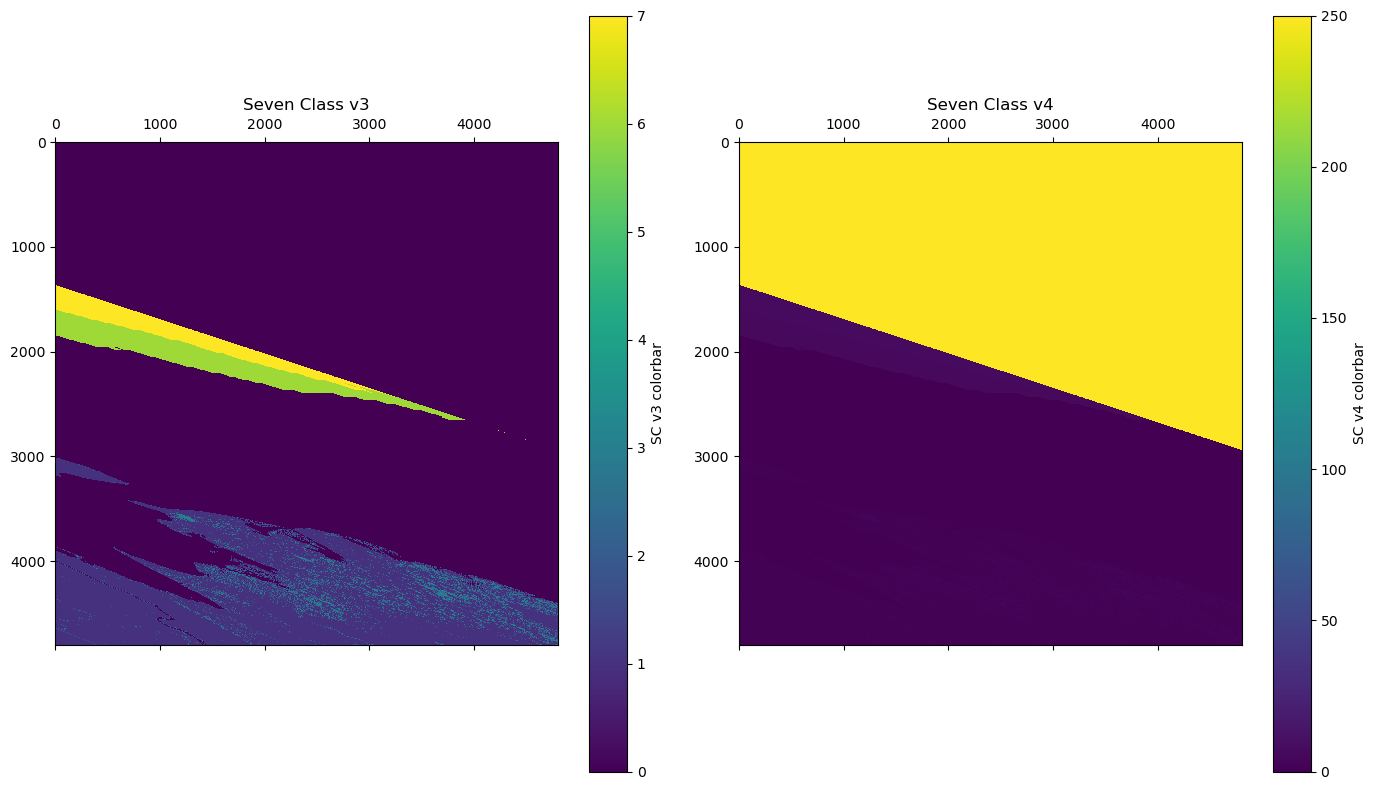

In [35]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

# Plot the first matrix with its own colorbar
cax1 = ax1.matshow(mod44w_v3_c61_seven_class_data_array.sel(band=1), cmap='viridis')
ax1.set_title('Seven Class v3')
cbar1 = fig.colorbar(cax1, ax=ax1)
cbar1.set_label('SC v3 colorbar')

# Plot the second matrix with its own colorbar
cax2 = ax2.matshow(mod44w_v4_c61_seven_class_data_array.sel(band=1), cmap='viridis')
ax2.set_title('Seven Class v4')
cbar2 = fig.colorbar(cax2, ax=ax2)
cbar2.set_label('SC v4 colorbar')

plt.tight_layout()
plt.show()

## Plot difference between v3 and v4 seven class products (shared)

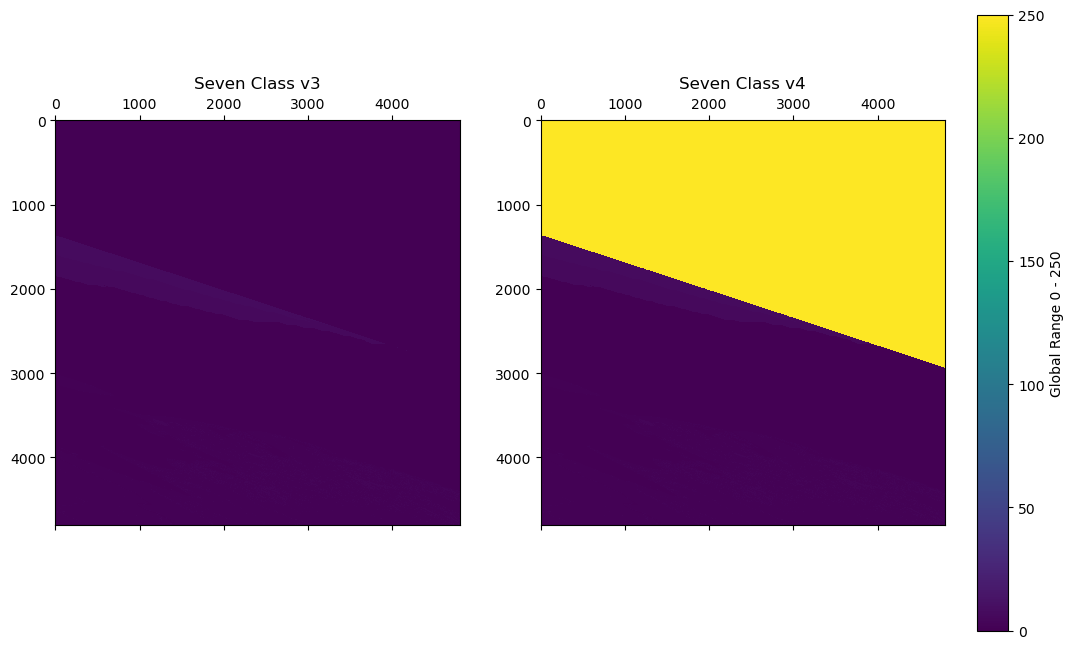

In [36]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

# Plot the first matrix
cax1 = ax1.matshow(mod44w_v3_c61_seven_class_data_array.sel(band=1), cmap='viridis', vmin=0, vmax=250)
ax1.set_title('Seven Class v3')

# Plot the second matrix
cax2 = ax2.matshow(mod44w_v4_c61_seven_class_data_array.sel(band=1), cmap='viridis', vmin=0, vmax=250)
ax2.set_title('Seven Class v4')

# Create a common colorbar for both plots
cbar = fig.colorbar(cax2, ax=[ax1, ax2], pad=0.03)
cbar.set_label('Global Range 0 - 250')

# plt.tight_layout()
plt.show()